# Description
This notebook shows how one could load and visualize an experimental image.

The general purpose libraries we will explore briefly:
* [PIL](https://python-pillow.org/)
* [scikit-image](https://scikit-image.org/)
* [numpy](https://numpy.org/)
* [matplotlib](https://matplotlib.org/stable/index.html)
* [matplotlib-scalebar](https://pypi.org/project/matplotlib-scalebar/)

I will also mention domain specific libraries:
* [hyperspy](https://hyperspy.org/)

# Importing the necessary libraries

In [25]:
%matplotlib notebook

In [28]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# Importing an image

In [7]:
image = Image.open("./example_image.tif")

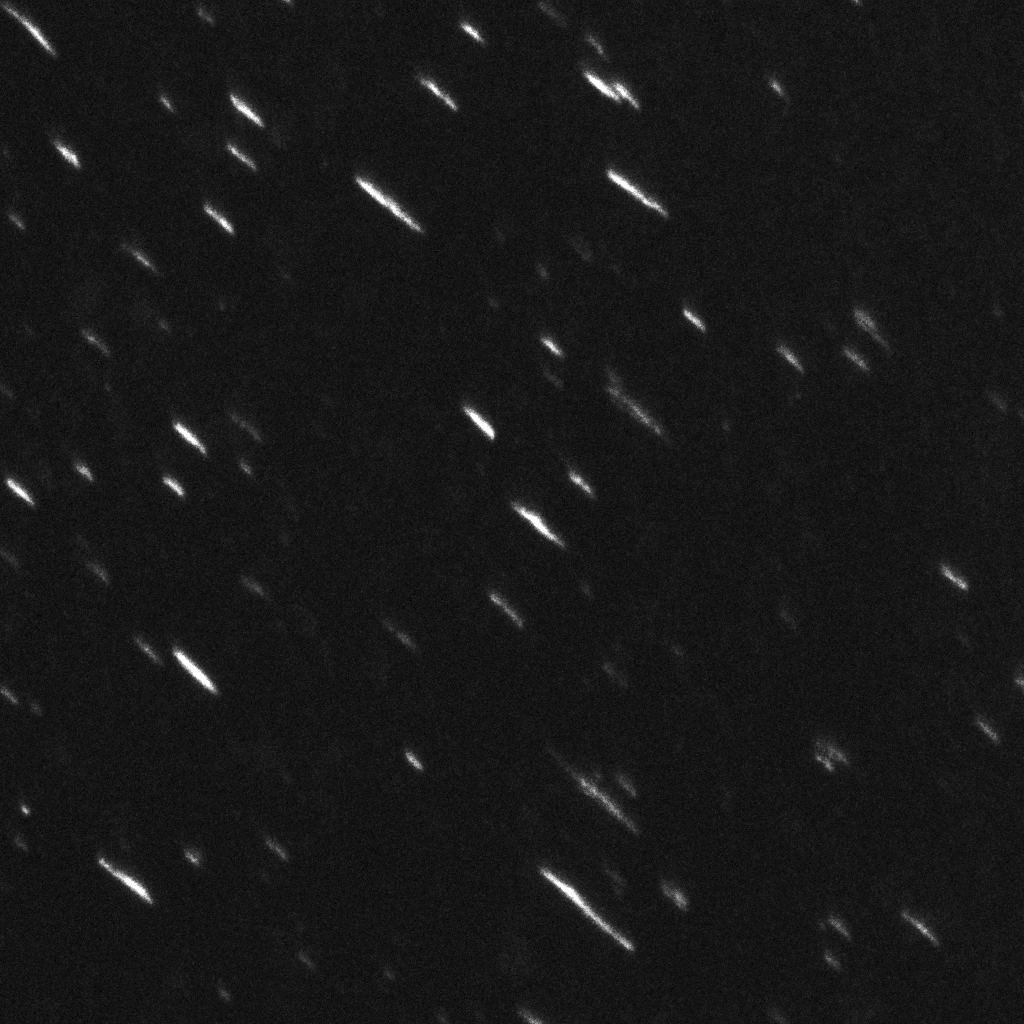

In [8]:
image

# Basic image processing
The image contains some noise and bad contrast. We try to apply a simple filter for some denoising and adjust intensity levels with the gamma parameter.

In [79]:
data = np.array(image)
# information about the original image
print(data.dtype)
print(data.shape)
print(data)

from skimage import img_as_float64
from skimage.filters import median
from skimage.morphology import disk  # make a white circle which acts as the "kernel"
from skimage.exposure import adjust_gamma

# convert range from 0 - 1
data = img_as_float64(data)
# median filter
data = median(data, selem = disk(5))
# boost contrast by applying a pixel-wise power to the intensity
data = adjust_gamma(data, 0.2)

uint8
(1024, 1024)
[[33 35 33 ... 24 22 29]
 [44 35 42 ... 31 26 24]
 [54 44 42 ... 22 20 20]
 ...
 [26 18 11 ... 22 24 20]
 [20 20 26 ... 22 26 20]
 [22 20 16 ... 24 20 26]]


# Plotting the data
Here we create some plots for the image. Let's add a scalebar, some text, a colorbar, an arrow, etc

<IPython.core.display.Javascript object>


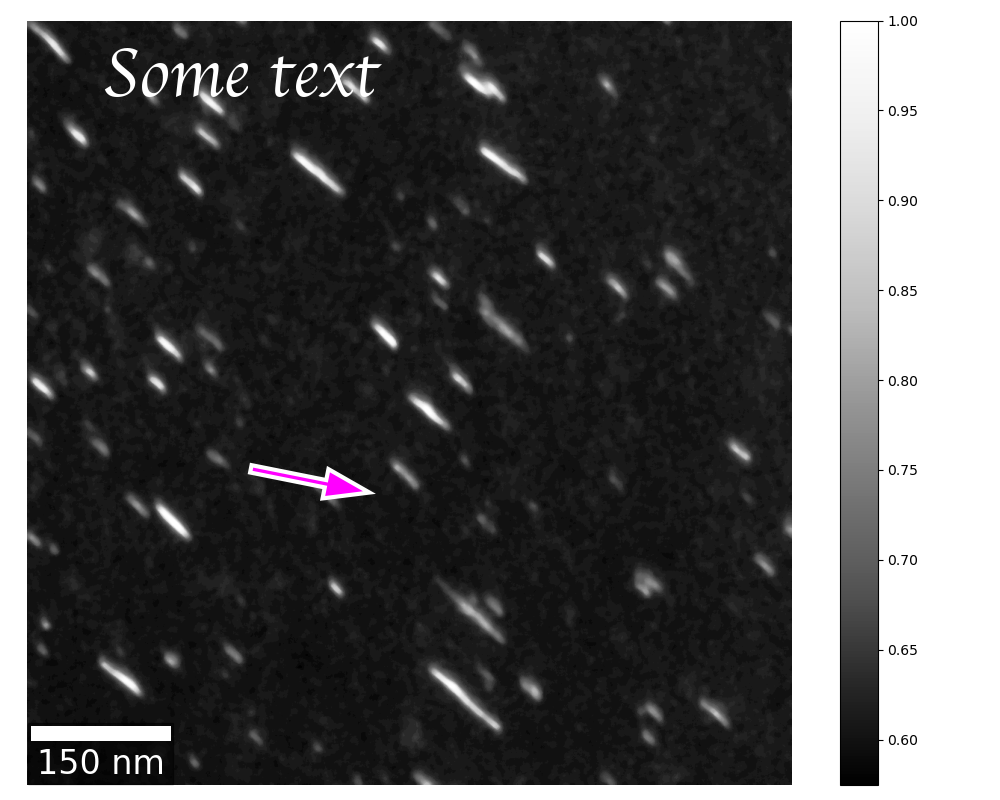

In [235]:
# creating a figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data, cmap = "Greys_r")
fig.colorbar(im, ax=ax)

# adding a scalebar
sb_options = {
             "location": "lower left",
             "color" : "white",
             "frameon": True,
             "box_color": "black",
             "box_alpha": 0.5,
             "font_properties": {
                 "size": 24
             },
             "label_loc": "top",
             "scale_loc": "bottom",
             "height_fraction": 0.02,
             "sep": 5 
             }
scalebar = ScaleBar(0.8, 'nm', **sb_options)
ax.add_artist(scalebar)

# some other features as demonstration, 
# see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot
ax.text(100, 100, "Some text", fontsize=50, color="white", fontfamily="cursive")
ax.arrow(300, 600, 100, 20, facecolor="magenta", edgecolor="white", linewidth=3,
         width=10, head_width = 40)

ax.axis("off") # turn off the ticks and labels
fig.tight_layout()

# Feature detection and segmentation
We want to segment out the features and get some information about them. For this we need to somehow detect what is a feature and separate it from the rest. The simplest way to do this is with intensity thresholding. But what threshold value should we use? There are various implementation for finding a threshold value, they can be explored automatically

In [96]:
from skimage.filters import try_all_threshold

<IPython.core.display.Javascript object>


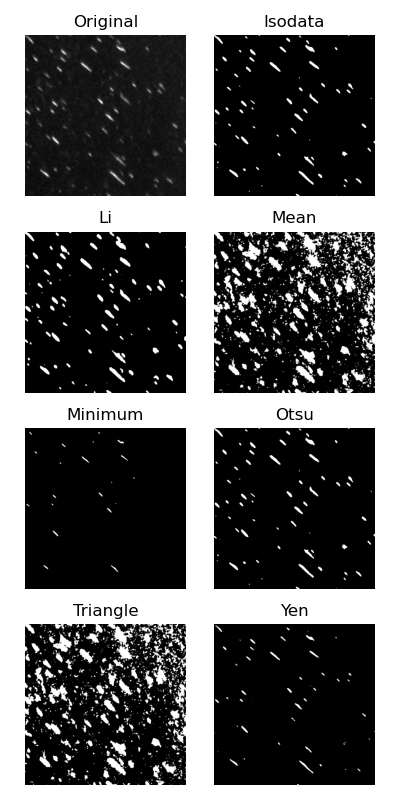

In [98]:
fig, ax = try_all_threshold(data, figsize=(4, 8), verbose=False)
plt.show()

In [99]:
# Li looks quite promising
from skimage.filters import threshold_li

In [100]:
thresh = threshold_li(data)
print(thresh)
binary_image = data > thresh

0.6553848905728487


<IPython.core.display.Javascript object>


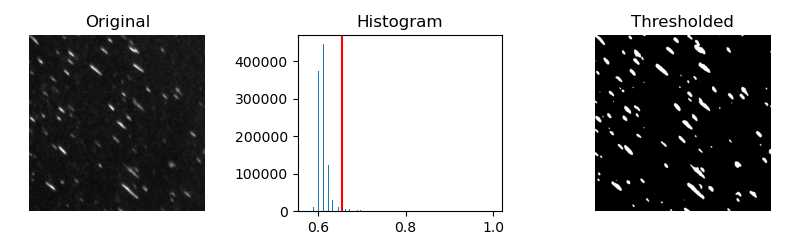

In [105]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()

ax[0].imshow(data, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(data.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary_image, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
fig.tight_layout()

Now we want to disconnect the individual features and give them a different "label". This can be done very easily.

In [143]:
import skimage.measure as measure

In [194]:
labels = measure.label(binary_image)

<IPython.core.display.Javascript object>


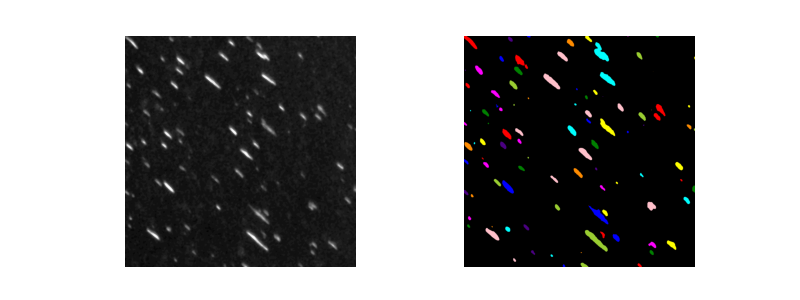

In [196]:
from skimage.color import label2rgb

fig, ax = plt.subplots(ncols=2, figsize = (8, 3))
ax = ax.ravel()
ax[0].imshow(data, cmap="Greys_r")
ax[1].imshow(label2rgb(labels, bg_label=0))
for i in ax:
    i.axis("off")

In [197]:
# number of features
labels.max()

102

Now we can explore features of these labeled regions, like the maximum length. We can then create histograms of this.

In [198]:
from skimage.measure import regionprops_table

In [199]:
metrics = regionprops_table(labels, properties=['label', 'area', 'major_axis_length'])

<IPython.core.display.Javascript object>


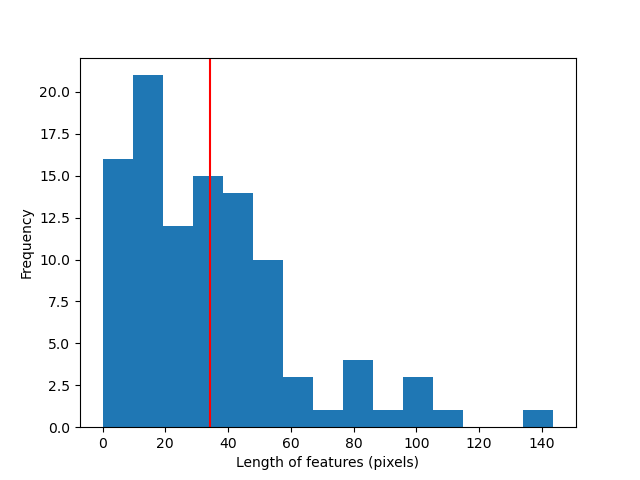

In [200]:
fig, ax = plt.subplots()
ax.hist(metrics["major_axis_length"], bins=15)
ax.set_ylabel("Frequency")
ax.set_xlabel("Length of features (pixels)")
ax.axvline(np.mean(metrics["major_axis_length"]), color="red")

# Can we improve?
Simple thresholding can cause different features to be lumped together because they are connected. Could we improve this in some way, e.g. with watershed?

In [236]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [220]:
# the minimum distance of each pixel to the nearest black pixel
distance = ndi.distance_transform_edt(binary_image*1)
distance[distance <= 0] = 0

# find the coordinates of maxima in this distance image
coords = peak_local_max(distance, 
                        labels=labels,
                        num_peaks_per_label = 2,
                        min_distance=10
                        )

# map the coordinates to an array of the same size as the image
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

new_labels = watershed(-distance, markers, mask=binary_image)

In [237]:
# number of "peaks" that were identified
markers.max()

103

<IPython.core.display.Javascript object>


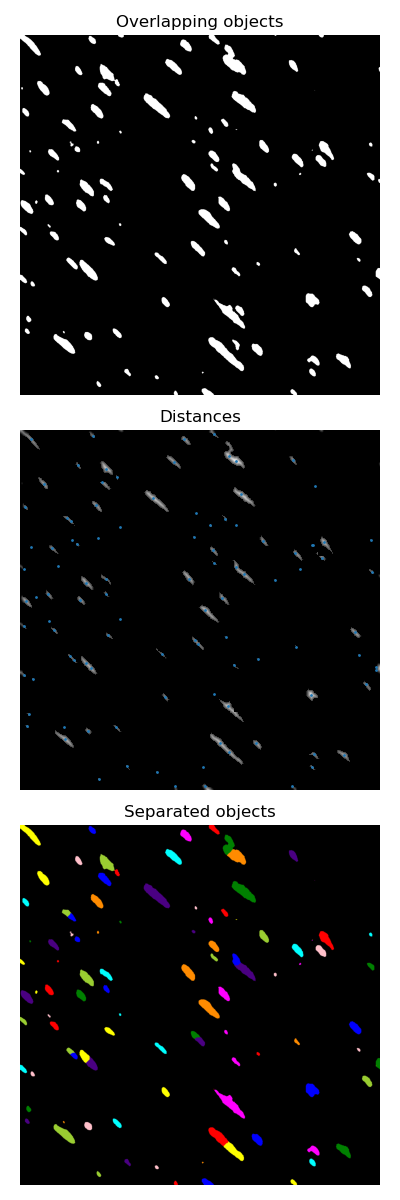

In [238]:
fig, axes = plt.subplots(nrows=3, figsize=(4, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(binary_image, cmap="Greys_r")
ax[0].set_title('Overlapping objects')

ax[1].imshow(distance, cmap=plt.cm.gray, vmin=0)
ax[1].set_title('Distances')
ax[1].scatter(coords[:,1], coords[:,0], s = 1)

ax[2].imshow(label2rgb(new_labels, bg_label=0))
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()

In this case it doesn't work much better and incorrectly splits some of the features, there are other approaches one could take, see the [various examples](https://scikit-image.org/docs/stable/auto_examples/index.html) on the scikit image website, but we won't explore them here. 

Image processing in general is a very iterative process and may require significant time investment for each project. But once a good procedure has been found, processing new images using an existing pipeline is relatively straightforward.

# Hyperspy
Often times, experimental data is not in TIFF, png or jpg format. Most of those experimental data files (if they are images or microscopy datasets) using hyperspy. Hyperspy also comes bundled with a number of nice analysis and visualisation routines, and automatically deals with metadata like pixel scale for you. Just as an example, we load and plot a dataset from a proprietary format.

In [239]:
import hyperspy.api as hs

/Users/nielscautaerts/opt/anaconda3/envs/devel/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [240]:
dataset = hs.load("example_proprietary.dm3")

In [241]:
dataset

<Signal2D, title: 2B-CD-60k, dimensions: (|1024, 1024)>

<IPython.core.display.Javascript object>


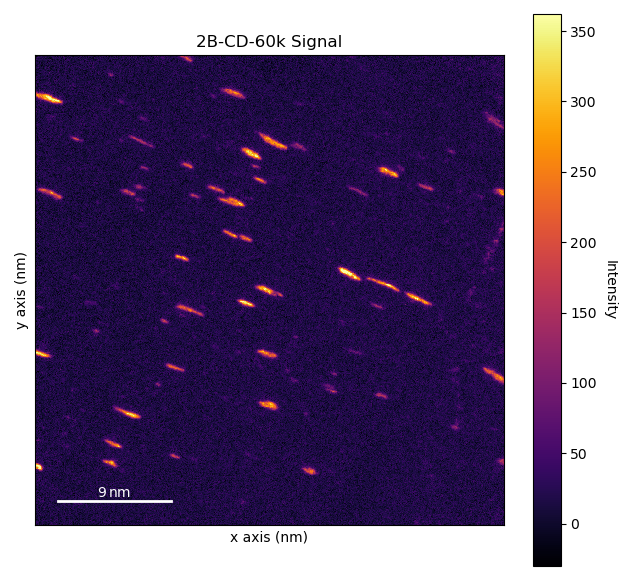

In [242]:
dataset.plot(cmap="inferno")

Unfortunately the scale in this image is incorrect because of an incorrect calibration of the microscope, but you can see how a few routine analyses and quick visualisation can be sped up. If you don't know how to open the image file, try hyperspy.